# Notebook For The XGBOOST MODEL

In [1]:
#Import libraries
#xgboost version = 0.6a2 
#Idea of iterative parameter optimization adapted from:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
#import seaborn as sns
from sklearn import metrics
import warnings
#Ignore warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 4
plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

data = pd.read_csv('/Users/yusufadeshina/Downloads/final_full_dataset_goldi_like_for_models_new.csv')
target = 'Label'
IDcol = 'PDB'

/Users/yusuf/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yusuf/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    """
    Defines a function to fit model.
    
    If useTrainCV is set to True, the function uses the training data to carry out 10 fold cross-validation
    by reserving 10% of the training set for as a validation/dev set. These XGBoost internal cross validation optimizes 
    the number of estimator by optimizing roc_auc on the classification task.
    The optimum number of estimator is then used to train the entire training set; the resulting model is then evaluated 
    on an independent test set.
    
    """
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds,seed=27)
        print (cvresult.iloc[[0, -1]])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Label'], dtrain_predprob))
    print ("Accuracy(Test) : %.4g" % metrics.accuracy_score(dtest['Label'].values, dtest_predictions))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(dtest['Label'], dtest_predprob))
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)               
    #feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #feat_imp1 = pd.Series(alg.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances', figsize=(10,10))
    #feat_imp1.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return (dtrain_predictions,dtest_predictions,dtrain_predprob,dtest_predprob)

In [3]:
#Define a function to randomly split data set while preserving the ratio of actives vs decoys in the original set 
def stratify_train_test(df, stratifyby, *args, **kwargs):
    #Adapted from https://stackoverflow.com/questions/37969945/split-data-into-train-test-files-such-that-at-least-one-sample-is-picked-for-bo
    train, test = pd.DataFrame(), pd.DataFrame()
    gb = df.groupby(stratifyby)
    for k in gb.groups:
        traink, testk = cross_validation.train_test_split(gb.get_group(k), *args, **kwargs)
        train = pd.concat([train, traink])
        test = pd.concat([test, testk])
    return train, test


train, test = stratify_train_test(data, 'Label', test_size=.1,random_state=27)

print (len(train[(train['Label']==1)]))
print (len(train))
print (len(test[(test['Label']==1)]))
print (len(test))

1244
4943
139
550


##### Recall from Machine_Learning_Algorithm_Comparison_vScreenML.ipynb that baseline XGBoost model trained by 10-fold cross-validation optimizing accuracy results in:
Accuracy: 0.89;
Precision: 0.85;
Recall: 0.67;
ROC-AUC: 0.81;
Matthew's correlation coefficient: 0.68

### Baseline
##### Baseline with accuracy optimization swapped out for roc-auc optimization

    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.814294      0.018541        0.827131       0.003440
99       0.927526      0.014867        0.967864       0.001314

Model Report
Accuracy : 0.9213
AUC Score (Train): 0.966607
Accuracy(Test) : 0.8927
AUC Score (Test): 0.919025


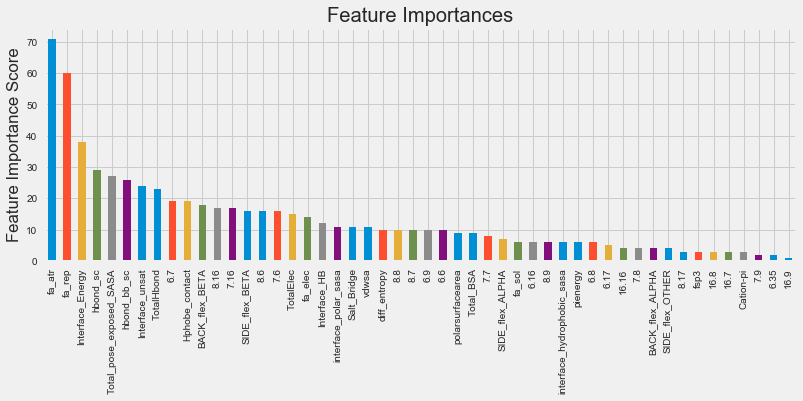

In [5]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb0 = XGBClassifier()
pred0 =modelfit(xgb0, train,test, predictors)

"""
Choose all predictors except target & IDcols
Get a baseline model
"""
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(seed=27)
pred1 =modelfit(xgb1, train,test, predictors)
"""
Summary of result:
This significantly improves the test ROC-AUC value (0.92) compared to when we were optimizing for accuracy (0.81).
Default n_estimators (100) maxed-out. Since, this is the maximum value, there is still room for improvement. In the next cell
will try to optimize n_estimators with larger value.
PS: We have to continuously optimize n_estimators as we optimize other parameters.
"""

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.826687      0.020770        0.863875       0.006277
368       0.943578      0.014424        1.000000       0.000000

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9145
AUC Score (Test): 0.941151


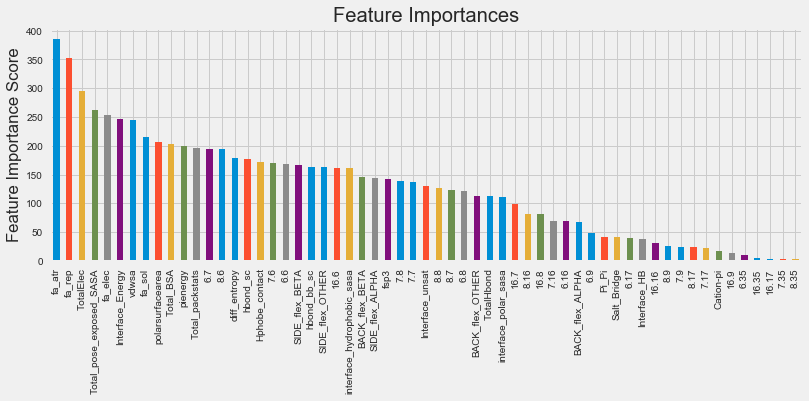

In [10]:
"""
Since the default n_estimator (100) was maxed out above, this means there is still room for larger n_estimator.
Here we increased the n_estimators to try to 1000.

Summary of result:
This improves the result further
"""
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=27)
pred1 =modelfit(xgb1, train,test, predictors)

In [11]:
"""
Summary of result:
Here the best values are:
{'max_depth': 7, 'min_child_weight': 1}, with further improvement of roc_auc to 0.9444340547156125. 
We fixed these parameters at this value while we optimized the other parameters. 
"""
param_test2 = {
 'max_depth':range(1,10,1),
 'min_child_weight':range(1,10,1)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=368, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.91620, std: 0.01676, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.91620, std: 0.01676, params: {'max_depth': 1, 'min_child_weight': 2},
  mean: 0.91650, std: 0.01654, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.91646, std: 0.01667, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.91630, std: 0.01661, params: {'max_depth': 1, 'min_child_weight': 5},
  mean: 0.91623, std: 0.01669, params: {'max_depth': 1, 'min_child_weight': 6},
  mean: 0.91584, std: 0.01682, params: {'max_depth': 1, 'min_child_weight': 7},
  mean: 0.91603, std: 0.01669, params: {'max_depth': 1, 'min_child_weight': 8},
  mean: 0.91587, std: 0.01685, params: {'max_depth': 1, 'min_child_weight': 9},
  mean: 0.93472, std: 0.01614, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.93381, std: 0.01694, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.93326, std: 0.01688, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.93447, std: 0.01638, params: {

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.831108      0.021452        0.893197       0.007955
367       0.944138      0.013259        1.000000       0.000000

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.92
AUC Score (Test): 0.939750


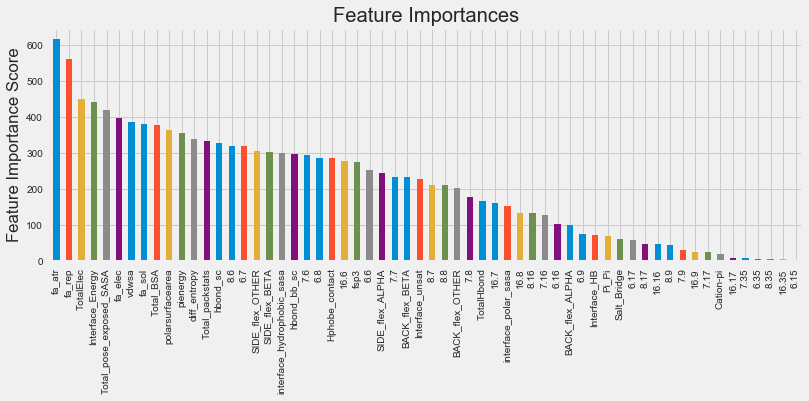

In [12]:
"""
fitting a new model with the best parameter and recalibrating the best n_estimators so far.

Summary of result:
The new best n_estimators 
"""
pred2 = modelfit(gsearch2.best_estimator_, train,test,predictors)

In [13]:
"""
Summary of result:
Here the best values is:
{'gamma': 0.1}, with further improvement of roc_auc to 0.9441451626606938. 
We fixed these parameters at this value while we optimized the other parameters. 
"""
param_test4 = {
 'gamma':[i/10.0 for i in range(1,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=367, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.94415, std: 0.01350, params: {'gamma': 0.1},
  mean: 0.94362, std: 0.01362, params: {'gamma': 0.2},
  mean: 0.94403, std: 0.01345, params: {'gamma': 0.3},
  mean: 0.94216, std: 0.01404, params: {'gamma': 0.4},
  mean: 0.94282, std: 0.01379, params: {'gamma': 0.5},
  mean: 0.94143, std: 0.01281, params: {'gamma': 0.6},
  mean: 0.94275, std: 0.01252, params: {'gamma': 0.7},
  mean: 0.94275, std: 0.01199, params: {'gamma': 0.8},
  mean: 0.94180, std: 0.01375, params: {'gamma': 0.9}],
 {'gamma': 0.1},
 0.9441451626606938)

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.831186      0.021457        0.893137       0.007971
667       0.944786      0.013056        1.000000       0.000000

Model Report
Accuracy : 1
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9145
AUC Score (Test): 0.942796


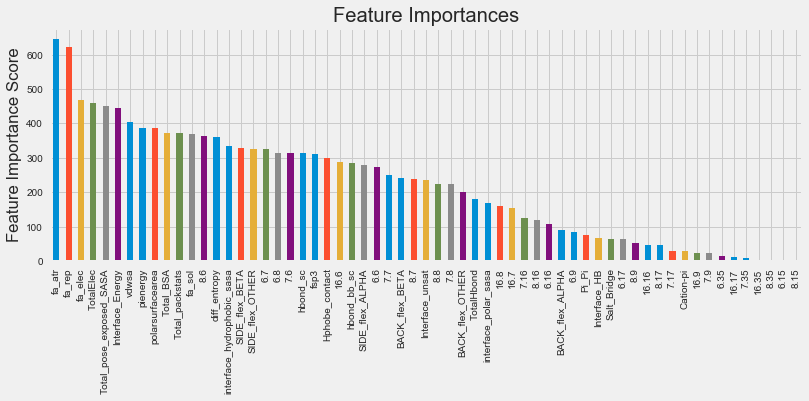

In [15]:
#recalibrating number of trees
"""
fitting a new model with the best parameter and recalibrating the best n_estimators so far.

Summary of result:
The new best n_estimators 
"""
xgb5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
pred5=modelfit(xgb5,train,test,predictors)

In [16]:
"""
Summary of result:
Here the best values are:
{'colsample_bytree': 0.4, 'subsample': 0.5}, with further improvement of roc_auc to 0.9450078472650463. 
We fixed these parameters at this value while we optimized the other parameters. 
"""
param_test5 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(1,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=667, max_depth=7,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.91688, std: 0.01881, params: {'subsample': 0.1, 'colsample_bytree': 0.1},
  mean: 0.92458, std: 0.01107, params: {'subsample': 0.2, 'colsample_bytree': 0.1},
  mean: 0.92903, std: 0.01438, params: {'subsample': 0.3, 'colsample_bytree': 0.1},
  mean: 0.93287, std: 0.01318, params: {'subsample': 0.4, 'colsample_bytree': 0.1},
  mean: 0.93188, std: 0.01461, params: {'subsample': 0.5, 'colsample_bytree': 0.1},
  mean: 0.93531, std: 0.01400, params: {'subsample': 0.6, 'colsample_bytree': 0.1},
  mean: 0.93486, std: 0.01560, params: {'subsample': 0.7, 'colsample_bytree': 0.1},
  mean: 0.93509, std: 0.01339, params: {'subsample': 0.8, 'colsample_bytree': 0.1},
  mean: 0.93462, std: 0.01251, params: {'subsample': 0.9, 'colsample_bytree': 0.1},
  mean: 0.92707, std: 0.01221, params: {'subsample': 0.1, 'colsample_bytree': 0.2},
  mean: 0.93814, std: 0.01410, params: {'subsample': 0.2, 'colsample_bytree': 0.2},
  mean: 0.93844, std: 0.01382, params: {'subsample': 0.3, 'colsample_bytree'

## Regularization

In [17]:
"""
Summary of result:
Here the best values si:
{'reg_alpha': 0}, with further improvement of roc_auc to 0.9450078472650463. 
No regularization needed. 
"""
param_test6 = {
 'reg_alpha':[0,1e-8,1e-7,1e-6 ]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=667, max_depth=7,
 min_child_weight=1, gamma=0.1, subsample=0.5, colsample_bytree=0.4,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.94501, std: 0.01224, params: {'reg_alpha': 0},
  mean: 0.94501, std: 0.01224, params: {'reg_alpha': 1e-08},
  mean: 0.94501, std: 0.01224, params: {'reg_alpha': 1e-07},
  mean: 0.94501, std: 0.01224, params: {'reg_alpha': 1e-06}],
 {'reg_alpha': 0},
 0.9450078472650463)

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.821153      0.019400        0.862989       0.005309
1945       0.946021      0.012494        1.000000       0.000000

Model Report
Accuracy : 0.9998
AUC Score (Train): 1.000000
Accuracy(Test) : 0.9145
AUC Score (Test): 0.942131


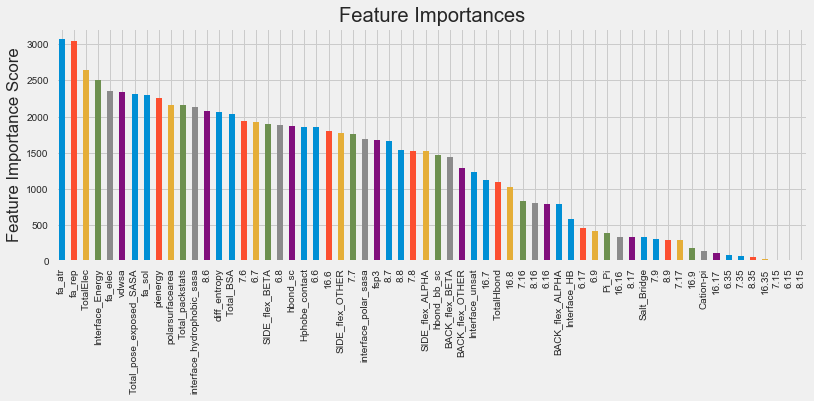

In [18]:
"""
Recalibrating the number of trees with all the optimized hyperparameter and saving the model. This is vScreenML model.
"""
import pickle
xgb7 = XGBClassifier(
learning_rate =0.01,
n_estimators=7000,
max_depth=7,
min_child_weight=1,
gamma=0.1,
subsample=0.5,
colsample_bytree=0.4,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27)
pred7=modelfit(xgb7, train,test, predictors)
model = xgb7.fit(train[predictors], train[target],eval_metric='auc')
# save model to file
with open("XGB_CLASSIFIER.pickle.dat", 'wb') as f:
    pickle.dump(model, f)



In [24]:
"""
Same as above but using the exact number of trees required.
"""
xgb8 = XGBClassifier(
learning_rate =0.01,
n_estimators=1945,
max_depth=7,
min_child_weight=1,
gamma=0.1,
subsample=0.5,
colsample_bytree=0.4,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27)
model = xgb8.fit(data[predictors], data[target],eval_metric='auc')
# save model to file
with open("XGB_CLASSIFIER_alldata.pickle.dat", 'wb') as f:
    pickle.dump(model, f)